In [1]:
import six
import sys
import time
import itertools
import pandas as pd
from imblearn.under_sampling import NearMiss
sys.modules['sklearn.externals.six'] = six
# import mlrose
import joblib
# sys.modules['sklearn.externals.joblib'] = j
import mlrose_hiive as mlrose
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve, validation_curve

np.random.seed(42)

In [2]:
df = pd.read_csv("./data/Breast_Cancer.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Age                     4024 non-null   int64 
 1   Race                    4024 non-null   object
 2   Marital Status          4024 non-null   object
 3   T Stage                 4024 non-null   object
 4   N Stage                 4024 non-null   object
 5   6th Stage               4024 non-null   object
 6   differentiate           4024 non-null   object
 7   Grade                   4024 non-null   object
 8   A Stage                 4024 non-null   object
 9   Tumor Size              4024 non-null   int64 
 10  Estrogen Status         4024 non-null   object
 11  Progesterone Status     4024 non-null   object
 12  Regional Node Examined  4024 non-null   int64 
 13  Reginol Node Positive   4024 non-null   int64 
 14  Survival Months         4024 non-null   int64 
 15  Stat

In [3]:
df.describe()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Survival Months
count,4024.000000,4024.000000,4024.000000,4024.000000,4024.000000
mean,53.972167,30.473658,14.357107,4.158052,71.297962
std,8.963134,21.119696,8.099675,5.109331,22.921430
min,30.000000,1.000000,1.000000,1.000000,1.000000
25%,47.000000,16.000000,9.000000,1.000000,56.000000
50%,54.000000,25.000000,14.000000,2.000000,73.000000
75%,61.000000,38.000000,19.000000,5.000000,90.000000
max,69.000000,140.000000,61.000000,46.000000,107.000000


In [4]:
X_num = df[['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive']]
X_cat = df.drop(['Age', 'Tumor Size', 'Regional Node Examined', 'Reginol Node Positive', 'Status'], axis=1)
y = df['Status']

In [5]:
le = LabelEncoder()
y = le.fit_transform(y)
for col in X_cat.columns:
  X_cat[col] = le.fit_transform(X_cat[col])

In [6]:
X = pd.concat([X_num, X_cat], axis=1)
X.head()

,Age,Tumor Size,Regional Node Examined,Reginol Node Positive,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Estrogen Status,Progesterone Status,Survival Months
0,68,4,24,1,2,1,0,0,0,1,3,1,1,1,59
1,50,35,14,5,2,1,1,1,2,0,2,1,1,1,61
2,58,63,14,7,2,0,2,2,4,0,2,1,1,1,74
3,58,18,2,1,2,1,0,0,0,1,3,1,1,1,83
4,47,41,3,1,2,1,1,0,1,1,3,1,1,1,49


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Randominzed Hill Climbing - restart

Processing restart=0
Training Begins...
Training Time: 42.36881113052368
Traing Accuracy: 0.8402915838303512

Processing restart=50
Training Begins...
Training Time: 1722.850406885147
Traing Accuracy: 0.8396288933068257

Processing restart=100
Training Begins...
Training Time: 3467.746460914612
Traing Accuracy: 0.8409542743538767

Processing restart=150
Training Begins...
Training Time: 5240.298623085022
Traing Accuracy: 0.839297548045063



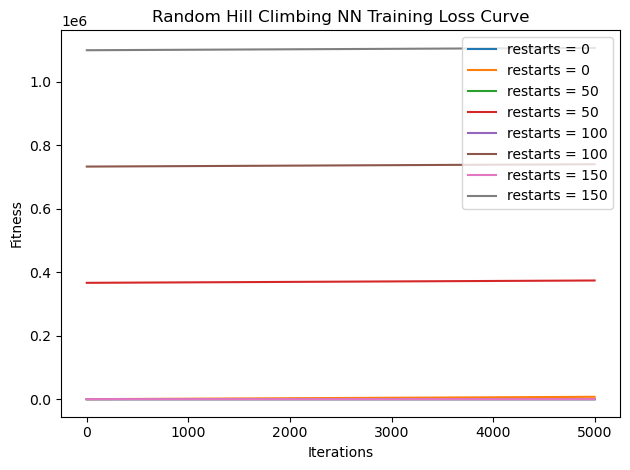

In [9]:
restarts_candidates = [0, 50, 100, 150]
rhc_nn_model_results = []

for r_val in restarts_candidates:
    print(f"Processing restart={r_val}")

    nn_model_rhc = mlrose.NeuralNetwork(hidden_nodes=[100],  # Matches MLPClassifier's default
                                      activation='relu',  # Default activation in MLPClassifier
                                      algorithm='random_hill_climb',  # Equivalent to using SGD with a fixed learning rate
                                      max_iters=5000,  
                                      bias=True,
                                      is_classifier=True,
                                      learning_rate=0.001,  
                                      early_stopping=True,  # Mimic MLPClassifier's behavior
                                      clip_max=5,  
                                      max_attempts=100,
                                      curve=True,
                                      restarts=r_val,
                                      random_state=42)
    print("Training Begins...")
    start_time = time.time()
    nn_model_rhc.fit(X_train_scaled, y_train)
    end_time = time.time()
    rhc_nn_model_results.append(nn_model_rhc.fitness_curve.copy())

    y_train_pred = nn_model_rhc.predict(X_train_scaled)
    y_train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Time: {end_time-start_time}")
    print(f"Traing Accuracy: {y_train_accuracy}")
    print()



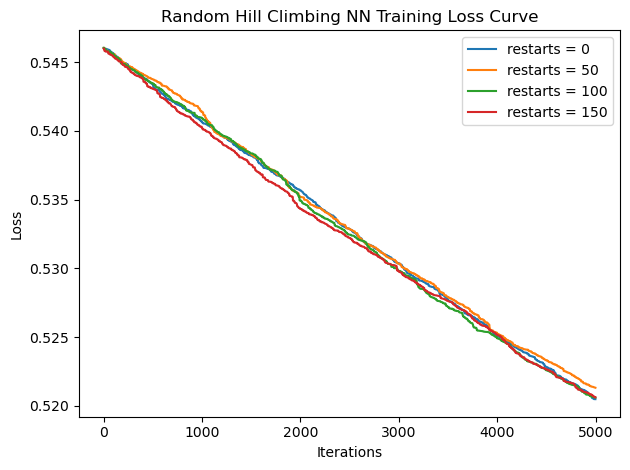

In [39]:
plt.figure()
for r_val,i in zip(restarts_candidates, rhc_nn_model_results):
    plt.plot(abs(i[:, 0]), label="restarts = {}".format(r_val), linewidth=1.5)

plt.title("Random Hill Climbing NN Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Simulated Annealing - init_temp, decay, min_temp

Processing schedule = ('GeomDecay', GeomDecay(init_temp=10, decay=0.1, min_temp=0.01))
Training Begins...
Training Time: 42.939757108688354
Traing Accuracy: 0.8459244532803181

Processing schedule = ('GeomDecay', GeomDecay(init_temp=10, decay=0.1, min_temp=0.1))
Training Begins...
Training Time: 42.421488761901855
Traing Accuracy: 0.8459244532803181

Processing schedule = ('GeomDecay', GeomDecay(init_temp=10, decay=0.1, min_temp=1))
Training Begins...
Training Time: 42.98282194137573
Traing Accuracy: 0.8459244532803181

Processing schedule = ('GeomDecay', GeomDecay(init_temp=10, decay=0.4, min_temp=0.01))
Training Begins...
Training Time: 42.21988487243652
Traing Accuracy: 0.8459244532803181

Processing schedule = ('GeomDecay', GeomDecay(init_temp=10, decay=0.4, min_temp=0.1))
Training Begins...
Training Time: 42.300591230392456
Traing Accuracy: 0.8459244532803181

Processing schedule = ('GeomDecay', GeomDecay(init_temp=10, decay=0.4, min_temp=1))
Training Begins...
Training Time: 42.1

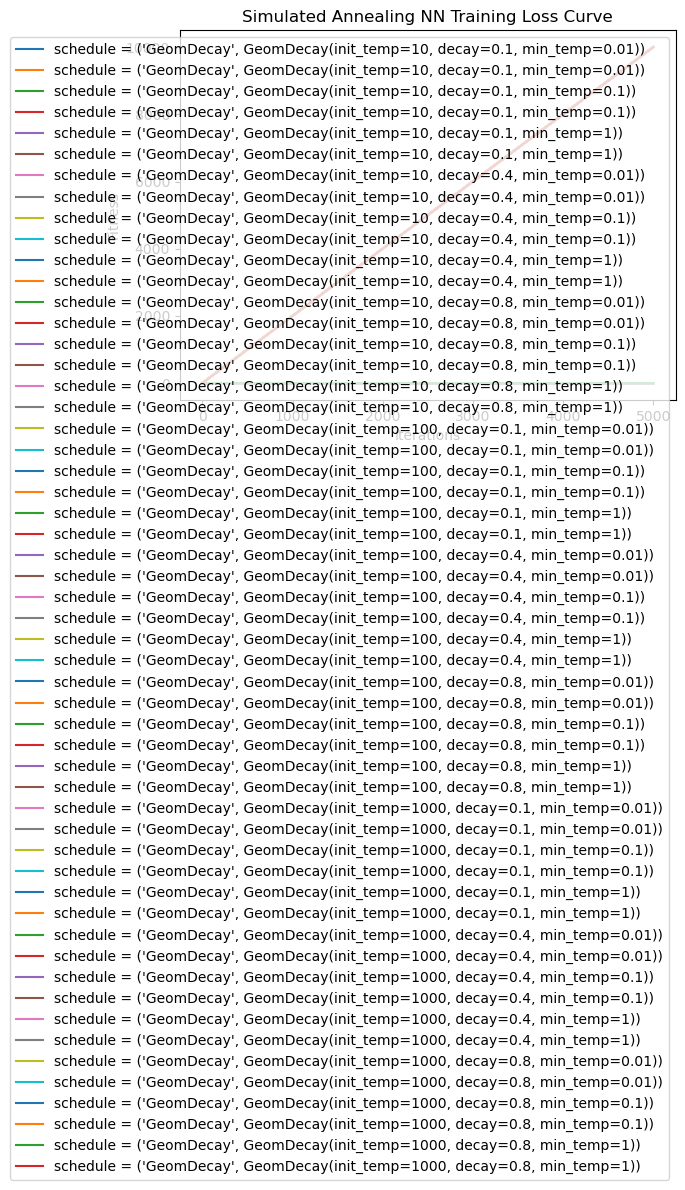

In [10]:
sa_parameter_candidate = [
    [10, 100, 1000], #init_temp
   [0.1, 0.4, 0.8], #decay
   [0.01, 0.1, 1] #min_temp, exp_const
]
sa_nn_model_results = []
sa_parameters = []

for sa_hyperparameter in itertools.product(*sa_parameter_candidate):
    init_temp, decay, min_temp = sa_hyperparameter
    sa_decay_candididate = ("GeomDecay",mlrose.GeomDecay(init_temp=init_temp, decay=decay, min_temp=min_temp))
                          
    print(f"Processing schedule = {sa_decay_candididate}") 
    sa_parameters.append(sa_decay_candididate)
    nn_model_sa = mlrose.NeuralNetwork(hidden_nodes=[100],  # Matches MLPClassifier's default
                                        activation='relu',  # Default activation in MLPClassifier
                                        algorithm='simulated_annealing',  # Equivalent to using SGD with a fixed learning rate
                                        max_iters=5000,  
                                        bias=True,
                                        is_classifier=True,
                                        learning_rate=0.001, 
                                        early_stopping=True,  # Mimic MLPClassifier's behavior
                                        clip_max=5, 
                                        max_attempts=100,
                                        curve=True,
                                        schedule=sa_decay_candididate[1],
                                        random_state=42)
        
    print("Training Begins...")
    start_time = time.time()
    
    nn_model_sa.fit(X_train_scaled, y_train)
    sa_nn_model_results.append(nn_model_sa.fitness_curve.copy())
    end_time = time.time()

    y_train_pred = nn_model_sa.predict(X_train_scaled)
    y_train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Time: {end_time-start_time}")
    print(f"Traing Accuracy: {y_train_accuracy}")
    print()

plt.figure()
for d_val,i in zip(sa_parameters, sa_nn_model_results):
    plt.plot(i, label="schedule = {}".format(d_val), linewidth=1.5)

plt.title("Simulated Annealing NN Training Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Fitness")
plt.legend(loc='best')
plt.tight_layout()
plt.show()
        
        


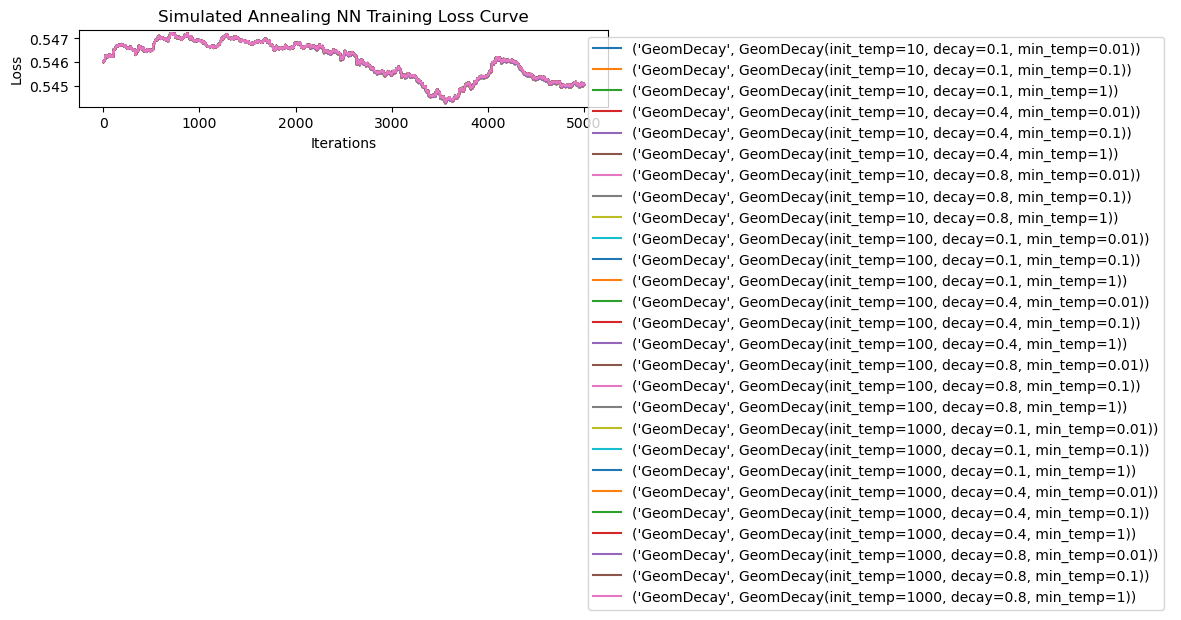

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})
for d_val,i in zip(sa_parameters, sa_nn_model_results):
    axs[0].plot(i[:, 0], label="{}".format(d_val), linewidth=1.5)

axs[0].set_title("Simulated Annealing NN Training Loss Curve")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Loss")

# Creating legend on the second subplot
handles, labels = axs[0].get_legend_handles_labels()
axs[1].legend(handles, labels, loc='best')
axs[1].axis('off')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Genetic Algorithm - pop_size, mutation_prob

In [36]:
ga_parameter_candidate = [
    [100, 200, 400, 600], # pop_size
   [0.2, 0.5, 0.8] #mutation_prob
]
ga_nn_model_results=[]
ga_parameters = []

for ga_hyperparameter in itertools.product(*ga_parameter_candidate):
    pop_size, mutation_prob = ga_hyperparameter
    print(f"Processing pop_size & mutation_prob = {pop_size}, {mutation_prob}") 
    ga_parameters.append((pop_size, mutation_prob))
    nn_model_ga = mlrose.NeuralNetwork(hidden_nodes=[100],  # Matches MLPClassifier's default
                                      activation='relu',  # Default activation in MLPClassifier
                                      algorithm='genetic_alg',  # Equivalent to using SGD with a fixed learning rate
                                      max_iters=5000,  
                                      bias=True,
                                      is_classifier=True,
                                      learning_rate=0.001,  
                                      early_stopping=True,  # Mimic MLPClassifier's behavior
                                      clip_max=5,  
                                      max_attempts=100,
                                      curve=True,
                                      pop_size=pop_size,
                                      mutation_prob=mutation_prob,
                                      random_state=42)
    
    print("Training Begins...")
    start_time = time.time()

    nn_model_ga.fit(X_train_scaled, y_train)
    end_time = time.time()
    ga_nn_model_results.append(nn_model_ga.fitness_curve.copy())

    y_train_pred = nn_model_ga.predict(X_train_scaled)
    y_train_accuracy = accuracy_score(y_train, y_train_pred)
    print(f"Training Time: {end_time-start_time}")
    print(f"Traing Accuracy: {y_train_accuracy}")
    print()

# plt.figure()
# for g_val,i in zip(ga_parameters, ga_nn_model_results):
#     plt.plot(i, label="pop_size & mutation_prob = {}".format(g_val), linewidth=1.5)

# plt.title("Genetic Algorithm NN Training Loss Curve")
# plt.xlabel("Iterations")
# plt.ylabel("Fitness")
# plt.legend(loc='best')
# plt.tight_layout()
# plt.show()

Processing pop_size & mutation_prob = 100, 0.2
Training Begins...
Training Time: 66.85693693161011
Traing Accuracy: 0.8475811795891319

Processing pop_size & mutation_prob = 100, 0.5
Training Begins...
Training Time: 82.73583674430847
Traing Accuracy: 0.8449304174950298

Processing pop_size & mutation_prob = 100, 0.8
Training Begins...
Training Time: 68.19690108299255
Traing Accuracy: 0.8638170974155069

Processing pop_size & mutation_prob = 200, 0.2
Training Begins...
Training Time: 152.65572714805603
Traing Accuracy: 0.8061630218687873

Processing pop_size & mutation_prob = 200, 0.5
Training Begins...
Training Time: 230.66800212860107
Traing Accuracy: 0.8522200132538105

Processing pop_size & mutation_prob = 200, 0.8
Training Begins...
Training Time: 127.87453508377075
Traing Accuracy: 0.8518886679920478

Processing pop_size & mutation_prob = 400, 0.2
Training Begins...
Training Time: 357.80958914756775
Traing Accuracy: 0.851557322730285

Processing pop_size & mutation_prob = 400, 0.

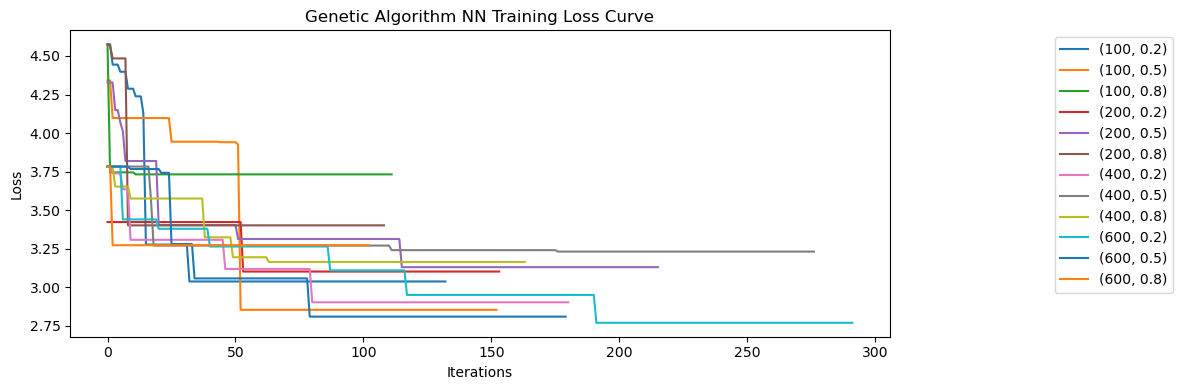

In [38]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'width_ratios': [3, 1]})

# # Plotting on the first subplot
# axs[0].plot([0, 1, 2], [10, 20, 15], label='Data 1', color='blue')
# axs[0].plot([0, 1, 2], [15, 10, 20], label='Data 2', color='red')
# axs[0].set_xlabel("X-axis")
# axs[0].set_ylabel("Y-axis")
# axs[0].set_title("Graph")

# # Creating legend on the second subplot
# handles, labels = axs[0].get_legend_handles_labels()
# axs[1].legend(handles, labels, loc='center')
# axs[1].axis('off')



# plt.figure()
for g_val,i in zip(ga_parameters, ga_nn_model_results):
    axs[0].plot(i[:, 0], label="{}".format(g_val), linewidth=1.5)

axs[0].set_title("Genetic Algorithm NN Training Loss Curve")
axs[0].set_xlabel("Iterations")
axs[0].set_ylabel("Loss")

# Creating legend on the second subplot
handles, labels = axs[0].get_legend_handles_labels()
axs[1].legend(handles, labels, loc='best')
axs[1].axis('off')
# plt.legend(loc='best')
plt.tight_layout()
plt.show()

[[...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...],
 [...]]